In [1]:
from __future__ import division
from pyoperators import pcg
from pysimulators import profile

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
from qubic import QubicSkySim as qss
import sys
sys.path.append('/Users/mregnier/Desktop/PhD Regnier/mypackages')


import Acquisition as Acq

# Display packages
import healpy as hp
import matplotlib.pyplot as plt

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# General packages
import numpy as np
import pysm3
import warnings
from qubic import QubicSkySim as qss
import pysm3.units as u
from importlib import reload
from pysm3 import utils

from qubic import SpectroImLib as sp
from importlib import reload
import gc
import copy


# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator)

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
# %matplotlib inline

## Now QUBIC and Planck acquisitions used for reconstruction

def display_maps(inputs, outputs, istk, display=True, rot=None, res=None, min=300, max=300, minr=-300, maxr=300, 
                 extra_string='', addnum=False, inside=None, cov=None):
    
    r = inputs[:, :, istk] - outputs[:, :, istk]
    Nf = outputs.shape[0]
    
    if cov is None:
        nx = 3
    else:
        nx = 4
        covnorm = cov/np.max(cov)
        uvpix = np.array(hp.pix2vec(hp.npix2nside(len(cov)), np.arange(len(cov))))
        uvcenter = np.array(hp.pix2vec(hp.npix2nside(len(cov)), np.argmax(cov)))
        dcenter = np.degrees(np.arccos(np.dot(uvpix.T, uvcenter)))
    
    all_rms_in = np.zeros(Nf)
    all_rms_out = np.zeros(Nf)
    
    stk=['I', 'Q', 'U']
    k=1
    for i in range(Nf): # Nf
        if addnum:
            addstr = '{}'.format(i)
        else:
            addstr=''
        if inside is not None:
            rms_in = np.std(r[i][inside])
            rms_out = np.std(r[i][~inside])
            all_rms_in[i] = rms_in
            all_rms_out[i] = rms_out
            addin = '\n $\sigma_{Qubic}$='+'{0:5.2g}'.format(rms_in)
        else:
            addin = ''
        hp.gnomview(inputs[i, :, istk], rot=rot, reso=res, cmap='jet', min=min, max=max, sub=(Nf, nx, k), title='Input'+ extra_string+addstr)
        k+=1
        hp.gnomview(outputs[i, :, istk], rot=rot, reso=res, cmap='jet', min=min, max=max, sub=(Nf, nx, k), title='Output'+ extra_string+addstr)
        k+=1
        hp.gnomview(r[i], rot=rot, reso=res, cmap='jet', min=minr, max=maxr, sub=(Nf, nx, k), title='Residual'+ extra_string+addstr+addin)
        k+=1
        if nx==4:
            x,y,sx,sy,_ = ft.profile(dcenter, r[i], nbins=40, rng=[0,35], plot=False)
            plt.subplot(2, nx, 4)
            plt.errorbar(x, y,yerr=sy, fmt='o')
            plt.xlabel('Radius [deg]')
            plt.ylabel('Mean')
            plt.ylim(-maxr, maxr)
            if istk==0:
                plt.ylim(-maxr*5, maxr*5)
            plt.subplot(2, nx, 8)
            plt.plot(x, sy,'o-')
            plt.xlabel('Radius [deg]')
            plt.ylabel('RMS Residuals')
            plt.ylim(0,maxr)
            if istk==0:
                plt.ylim(0, maxr*5)
            k+=1
        
    return all_rms_in, all_rms_out

def initial_guess_pcg(map, n, Nrec, npix):

    initial_guess = np.zeros((Nrec, npix, 3))
    for i in range(Nrec):
        initial_guess[i] = map + n
    
    return initial_guess


def integration(nu_min, nu_max, Nintegr, sky_config, d, fwhm_subbands = None):
    print(f'Integration from {nu_min:.2f} to {nu_max:.2f} GHz with {Nintegr} steps')
    obj = Acq.QubicIntegrated(d, Nsub=Nintegr, Nrec=Nintegr)
    if Nintegr == 1:
        allnus = np.array([np.mean([nu_min, nu_max])])
    else:
        allnus = np.linspace(nu_min, nu_max, Nintegr)
    print(allnus)
    m = obj.get_PySM_maps(sky_config, nus=allnus)
    
    if fwhm_subbands is not None:
        for i in range(Nintegr):
            C = HealpixConvolutionGaussianOperator(fwhm=fwhm_subbands[i])
            m[i] = C(m[i])
    
    return np.array([np.mean(m, axis=0)])

def initial_guess(map, nrec, fwhm = None, noisy = False):
    
    if fwhm is None:
        fwhm = [0]*nrec
    
    map_ini = np.zeros((nrec, map.shape[1], map.shape[2]))
    
    for i in range(nrec):
        #C = HealpixConvolutionGaussianOperator(fwhm = fwhm[i])
        #map_ini[i] = C(map[0])
        map_ini[i] = map[0]
        
    if nrec == 1:
        map_ini = map[0]
    
    return map_ini

# # %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import numpy as np
from pyoperators import *
import pyoperators

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/


In [2]:
reload(Acq)
nside = 256
relative_bandwidth = 0.25
band = 220
band_planck = 217
seed = 42
noiseless = False
effective_duration = 300000
rwplanck = 1.
tol = 1e-40
noise_planck_level = 0.000001
threshold = 0.


npointings = 1000
Nf_TOD = 4
Nf_recon = 2
fact_sub = 2

reload(Acq)

# Repository for dictionary
global_dir = Qubic_DataDir()
print(global_dir)
dictfilename = global_dir + 'dicts/pipeline_demo.dict'

# Read dictionary chosen
d_TOD = qubic.qubicdict.qubicDict()
d_TOD.read_from_file(dictfilename)

d_TOD['nf_recon'] = Nf_TOD
d_TOD['nf_sub'] = Nf_TOD
d_TOD['nside'] = nside
npix=12*d_TOD['nside']**2
d_TOD['RA_center'] = 0
d_TOD['DEC_center'] = -57
center = qubic.equ2gal(d_TOD['RA_center'], d_TOD['DEC_center'])
d_TOD['effective_duration'] = effective_duration
d_TOD['npointings'] = npointings
d_TOD['tol'] = 5e-4
d_TOD['filter_nu'] = band * 1e9
d_TOD['photon_noise'] = False#not noiseless
d_TOD['noiseless'] = noiseless
d_TOD['config'] = 'FI'
d_TOD['MultiBand'] = True
d_TOD['planck'] = True
d_TOD['dtheta'] = 15

print('*************** Noise **************')
print('Noisless:      {}'.format(d_TOD['noiseless']))
print('Photon Noise:  {}'.format(d_TOD['photon_noise']))
print('************************************')

#sky_config = {'cmb':3}
sky_config = {'cmb':3, 'dust':'d0'}

reload(Acq)
qubic_acquisition = Acq.QubicIntegrated(d_TOD, Nsub=Nf_TOD, Nrec=Nf_TOD)
cov = qubic_acquisition.get_coverage()
covnorm = cov/cov.max()
threshold = 0.05
seenpix = covnorm > threshold

m_sub = qubic_acquisition.get_PySM_maps(sky_config, qubic_acquisition.allnus)
print(m_sub.shape)

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
/Users/hamilton/Python/GitQubic/qubic/qubic/
*************** Noise **************
Noisless:      False
Photon Noise:  False
************************************
/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/
You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(4, 786432, 3)


In [3]:
H_TOD = qubic_acquisition.get_operator(convolution=True)
n_qubic = qubic_acquisition.get_noise()

TOD_QUBIC = H_TOD(m_sub).ravel() + n_qubic.ravel()

d_formaps = copy.deepcopy(d_TOD)
d_formaps['nf_recon'] = Nf_recon
d_formaps['nf_sub'] = Nf_recon * fact_sub


planck_acquisition = Acq.PlanckAcquisition(band_planck, qubic_acquisition.scene)
#planck_acquisition.sigma = A(planck_acquisition.sigma*1e6)
m_planck = integration(band_planck-35, band_planck+35, qubic_acquisition.Nsub, sky_config, d_formaps, fwhm_subbands=None)
n_planck = planck_acquisition.get_noise()

planck_for_nrec = np.zeros((Nf_recon, 12*nside**2, 3))
planck_for_nrec_noiseless = np.zeros((Nf_recon, 12*nside**2, 3))
for i in range(Nf_recon):
    target = np.mean(qubic_acquisition.allfwhm[i*fact_sub:(i+1)*fact_sub])
    
    C = HealpixConvolutionGaussianOperator(fwhm=target)
    planck_for_nrec[i] = C(m_planck[0] + (n_planck.copy() * noise_planck_level))
    planck_for_nrec_noiseless[i] = C(m_planck[0])

R = ReshapeOperator(planck_for_nrec.shape, (planck_for_nrec.shape[0]*planck_for_nrec.shape[1]*planck_for_nrec.shape[2]))
TOD_PLANCK = R(planck_for_nrec)

tod = np.r_[TOD_QUBIC, TOD_PLANCK]

#plt.plot(tod)
#qubic_acquisition = Acq.QubicIntegrated(d_formaps, Nsub=Nf_recon * fact_sub, Nrec=Nf_recon)

Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Making sum from 192.50 to 204.98
Making sum from 204.98 to 218.27
Making sum from 218.27 to 232.43
Making sum from 232.43 to 247.50
Integration from 182.00 to 252.00 GHz with 4 steps
You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.
[182.         205.33333333 228.66666667 252.        ]


In [4]:
d_formaps = copy.deepcopy(d_TOD)
d_formaps['nf_recon'] = Nf_recon
d_formaps['nf_sub'] = Nf_recon * fact_sub

qubic_acquisition = Acq.QubicIntegrated(d_formaps, Nsub=Nf_recon * fact_sub, Nrec=Nf_recon)
cov = qubic_acquisition.get_coverage()

You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.


In [5]:
cmb = qubic_acquisition.get_PySM_maps(sky_config, np.array([150]))[0]
cmb[seenpix] = 0

#H = qubic_acquisition.get_operator(convolution=False, convolve_to_max=False, fixed_data=cmb)
#invntt = qubic_acquisition.get_invntt_operator()

qubicplanck_acquisition = Acq.QubicPlanckMultiBandAcquisition(qubic_acquisition, planck_acquisition)

H = qubicplanck_acquisition.get_operator(convolution=False, convolve_to_max=False, fixed_data=cmb)
invN = qubicplanck_acquisition.get_invntt_operator(seenpix=None)

Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info MacJCH.local: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Making sum from 192.50 to 218.27
Making sum from 218.27 to 247.50
(786432,3)x(27771,3) fixeddata
(786432,3)x(27771,3) fixeddata
In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(991008, 991008)
905387052965142904678190040481792I
0
1


In [6]:
covnorm = cov/cov.max()
#seenpix = (cov > 0) & (covnorm > threshold)

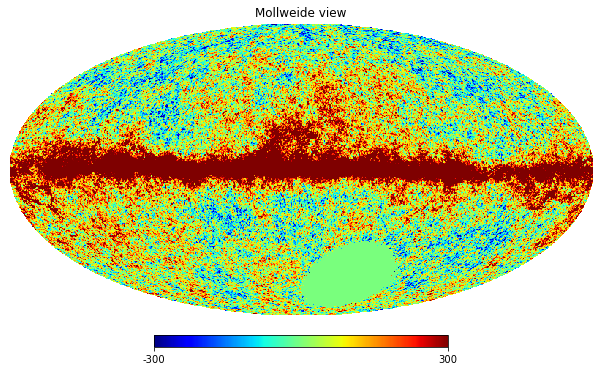

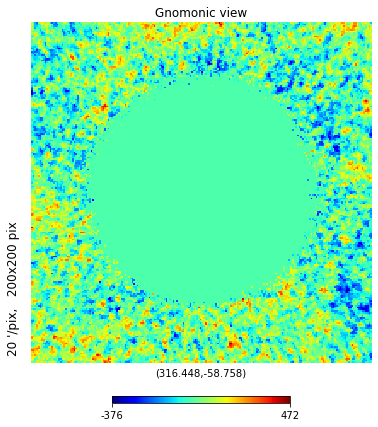

In [24]:
hp.mollview(cmb[:,0], min=-300,max=300, cmap='jet')
hp.gnomview(cmb[:,0], rot=center, reso=20, cmap='jet')

In [7]:
R=ReshapeOperator((992,qubic_acquisition.sampling.shape[0]), (992*qubic_acquisition.sampling.shape[0]))

In [8]:
A = H.T * invN * H#.operands[1]
b = H.T * invN * tod#[:qubic_acquisition.sampling.shape[0]*992]
M = Acq.get_preconditioner(np.ones(12*nside**2))

In [9]:
m_ini = planck_for_nrec.copy()
m_ini[:, seenpix] = 0
solution_qubic_planck = pcg(A, b, x0=None, M=M, tol=tol, disp=True, maxiter=60)

   1: 0.36696152998792286
   2: 0.24170862314472324
   3: 0.1134294330752241
   4: 0.06977345809872576
   5: 0.05513333915781551
   6: 0.05007965133543994
   7: 0.0330963767121368
   8: 0.025868214340803566
   9: 0.019703111023116962
  10: 0.015512457182968358
  11: 0.013066790530131546
  12: 0.01647526538729646
  13: 0.012340841117754804
  14: 0.008845827245039904
  15: 0.007997720002768409
  16: 0.006880168730389782
  17: 0.006518396351798479
  18: 0.007503314563279017
  19: 0.005689195238052755
  20: 0.0046487089560335385
  21: 0.00496180998058675
  22: 0.005987962928773544
  23: 0.004202227802885027
  24: 0.0049063658513878615
  25: 0.0033176915267207107
  26: 0.0030261474591896835
  27: 0.002781799933062994
  28: 0.0025844181208817163
  29: 0.002405761827759099
  30: 0.0023583272582334753
  31: 0.003554723605769175
  32: 0.0022280612806557863
  33: 0.002657834620467144
  34: 0.001956359255238926
  35: 0.0017370983373031805
  36: 0.001832082671610884
  37: 0.0020827067705395026
  3

In [10]:
qq = np.array([m_planck[0]]*Nf_recon).copy()
C = HealpixConvolutionGaussianOperator(fwhm=qubic_acquisition.final_fwhm[1])
print(qq.shape, np.sum(seenpix), solution_qubic_planck['x'].shape)
qq[:, seenpix] = solution_qubic_planck['x']
#qq[:, ~seenpix] += n_planck[~seenpix]

(2, 786432, 3) 27771 (2, 27771, 3)


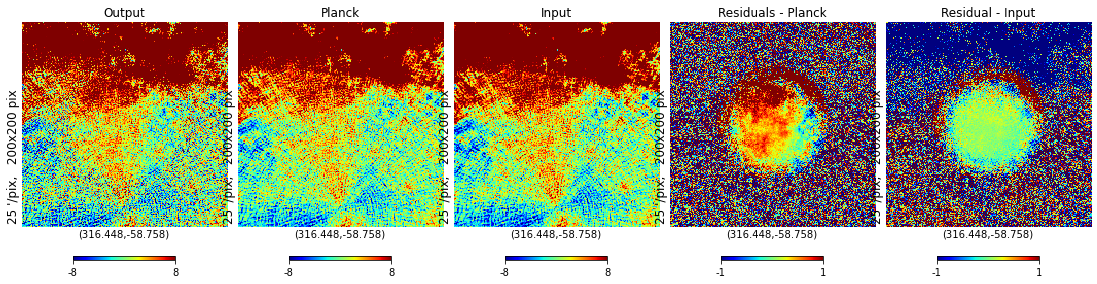

In [25]:
plt.figure(figsize=(15, 5))

res=25
istk=1
minr=1

hp.gnomview(qq[1, :, istk], cmap='jet', rot=center, reso=res, min=-8, max=8, sub=(1, 5, 1), title='Output')
hp.gnomview(C(m_planck[0])[:, istk], cmap='jet', rot=center, reso=res, min=-8, max=8, sub=(1, 5, 2), title='Planck')
hp.gnomview(C(np.mean(m_sub[fact_sub:2*fact_sub], axis=0))[:, istk], cmap='jet', rot=center, reso=res, min=-8, max=8, sub=(1, 5, 3), title='Input')

hp.gnomview(qq[1, :, istk]-(C(m_planck[0])[:, istk]), cmap='jet', rot=center, reso=res, min=-minr, max=minr, sub=(1, 5, 4), title='Residuals - Planck')
hp.gnomview(qq[1, :, istk]-C(np.mean(m_sub[fact_sub:2*fact_sub], axis=0))[:, istk], cmap='jet', rot=center, reso=res, title='Residual - Input',
                            min=-minr, max=minr, sub=(1, 5, 5))

plt.show()

In [12]:
A.shapein

(2, 27771, 3)

In [13]:
qubic_acquisition.final_fwhm[0]

0.005015249049472696

In [14]:
Hp = planck_acquisition.get_operator()

In [15]:
reload(Acq)

/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/


<module 'Acquisition' from '/Users/hamilton/Python/GitQubic/qubic/qubic/scripts/Tutorials-MapMaking/Acquisition.py'>

In [ ]:
H.T

In [ ]:
invN

In [ ]:
H.T * invN * H